# BioDynamICS: Dynamical Systems Modeling Demo

This notebook demonstrates the dynamical systems modeling capabilities of the BioDynamICS framework, which applies concepts from nonlinear dynamics to analyze physiological time series data.

## 1. Setup and Imports

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# Add the project root to path
project_root = r"C:\Users\alex5\Documents\Projects\MIMIC_III\biodynamics"
if project_root not in sys.path:
    sys.path.append(project_root)

# Import our custom modules
from src.data_integration import MimicPatientIntegrator
from src.signal_processing import PhysiologicalSignalProcessor
from src.dynamical_modeling import DynamicalSystemsModeler
from src.visualization import ClinicalVisualizer

In [3]:
# Configure visualization settings
plt.style.use('seaborn-v0_8-whitegrid')
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Load Patient Data

In [4]:
# Initialize data integrator with path to MIMIC data
data_path = r"C:\Users\alex5\Documents\Projects\MIMIC_III\biodynamics\data\mimic-iii-clinical-database-demo-1.4"
mimic = MimicPatientIntegrator(data_path)

# Load core tables
patient_stays = mimic.load_core_tables()

# Load CHARTEVENTS in chunks
print("Loading CHARTEVENTS in chunks...")
chartevents = mimic.load_chartevents_chunked(chunk_size=10000)

# Load other important tables for vital signs
tables_to_load = ["LABEVENTS", "PRESCRIPTIONS"]
for table in tables_to_load:
    print(f"Loading {table}...")
    mimic.load_table(table)

[2025-03-16 15:46:59] Initialized MimicPatientIntegrator
[2025-03-16 15:46:59] Loaded PATIENTS: 100 rows
[2025-03-16 15:46:59] Loaded ADMISSIONS: 129 rows
[2025-03-16 15:46:59] Loaded ICUSTAYS: 136 rows
[2025-03-16 15:46:59] Created patient stays table: 136 rows
Loading CHARTEVENTS in chunks...
[2025-03-16 15:46:59] Processing CHARTEVENTS.csv (74.1 MB)
[2025-03-16 15:46:59] Processed chunk 1 with 10000 rows. Total: 10000 rows
[2025-03-16 15:46:59] Processed chunk 2 with 10000 rows. Total: 20000 rows
[2025-03-16 15:46:59] Processed chunk 3 with 10000 rows. Total: 30000 rows
[2025-03-16 15:46:59] Processed chunk 4 with 10000 rows. Total: 40000 rows
[2025-03-16 15:46:59] Processed chunk 5 with 10000 rows. Total: 50000 rows
[2025-03-16 15:46:59] Processed chunk 6 with 10000 rows. Total: 60000 rows
[2025-03-16 15:46:59] Processed chunk 7 with 10000 rows. Total: 70000 rows
[2025-03-16 15:46:59] Processed chunk 8 with 10000 rows. Total: 80000 rows
[2025-03-16 15:46:59] Processed chunk 9 with 

## 3. Select a Patient with Good Data

In [5]:
# Function to find a patient with substantial data
def find_patient_with_good_data(mimic, min_events=100):
    """Find a patient with a substantial amount of data."""
    print("Searching for a patient with sufficient data...")
    patients = mimic.tables['PATIENTS']['subject_id'].tolist()
    
    patient_counts = {}
    for i, patient_id in enumerate(patients[:10]):  # Check first 10 patients
        print(f"Checking patient {i+1}/10: {patient_id}...")
        timeline = mimic.create_patient_timeline(patient_id)
        if 'timeline' in timeline and len(timeline['timeline']) > 0:
            event_count = len(timeline['timeline'])
            patient_counts[patient_id] = event_count
            print(f"  Found {event_count} events")
            if event_count >= min_events:
                print(f"  Sufficient data found!")
                return patient_id, timeline
    
    # If no patient meets the threshold, return the one with the most data
    if patient_counts:
        best_patient_id = max(patient_counts, key=patient_counts.get)
        print(f"Using patient {best_patient_id} with {patient_counts[best_patient_id]} events")
        return best_patient_id, mimic.create_patient_timeline(best_patient_id)
    
    # Fallback to first patient if none found
    patient_id = patients[0]
    return patient_id, mimic.create_patient_timeline(patient_id)

# Find a suitable patient
patient_id, patient_timeline = find_patient_with_good_data(mimic)

# Print patient info
print("\nPatient Information:")
for key, value in patient_timeline['info'].items():
    print(f"{key}: {value}")

# Show event count by type
timeline_df = patient_timeline['timeline']
print(f"\nTimeline summary: {len(timeline_df)} total events")
if 'event_type' in timeline_df.columns:
    print(timeline_df['event_type'].value_counts())

Searching for a patient with sufficient data...
Checking patient 1/10: 10006...
[2025-03-16 15:47:07] Created timeline for patient 10006 with 2937 events
  Found 2937 events
  Sufficient data found!

Patient Information:
subject_id: 10006
gender: F
dob: 2094-03-05 00:00:00
dod: 2165-08-12 00:00:00
expire_flag: 1
admissions: 1
icustays: 1

Timeline summary: 2937 total events
event_type
lab           1963
chart          920
medication      54
Name: count, dtype: int64


## 4. Initialize the Dynamical Systems Modeler

In [6]:
# Create the signal processor and dynamical systems modeler
signal_processor = PhysiologicalSignalProcessor()
ds_modeler = DynamicalSystemsModeler()
visualizer = ClinicalVisualizer()

# Extract heart rate time series as example for dynamical systems analysis
def extract_vital_sign_series(timeline_df, vital_sign='heart_rate'):
    """Extract a specific vital sign time series from the timeline."""
    # Check if the column exists directly
    if vital_sign in timeline_df.columns:
        # Get the data and sort by time
        vital_data = timeline_df[['measurement_time', vital_sign]].dropna()
        vital_data = vital_data.sort_values('measurement_time')
        
        # Convert to Series with time index
        vital_series = pd.Series(
            vital_data[vital_sign].values,
            index=pd.to_datetime(vital_data['measurement_time'])
        )
        return vital_series
    
    # If not, try to find it in MIMIC itemids
    elif 'itemid' in timeline_df.columns and 'valuenum' in timeline_df.columns:
        # Common MIMIC itemids for vital signs
        itemid_map = {
            'heart_rate': [211, 220045],
            'respiratory_rate': [618, 220210],
            'sbp': [51, 220050],
            'dbp': [8368, 220051],
            'temperature': [223761, 678]
        }
        
        # Check if we have a mapping for this vital sign
        if vital_sign in itemid_map:
            # Filter for the vital sign
            vital_itemids = itemid_map[vital_sign]
            vital_data = timeline_df[timeline_df['itemid'].isin(vital_itemids)].copy()
            
            if len(vital_data) > 0:
                # Sort by time
                vital_data['measurement_time'] = pd.to_datetime(vital_data['charttime'])
                vital_data = vital_data.sort_values('measurement_time')
                
                # Convert to Series with time index
                vital_series = pd.Series(
                    vital_data['valuenum'].values,
                    index=vital_data['measurement_time']
                )
                return vital_series
    
    # Return empty series if not found
    return pd.Series()

Initialized PhysiologicalSignalProcessor
- 29 clinical measures with reference ranges
- 8 organ systems defined
- 41 MIMIC itemIDs mapped to standard names
Initialized DynamicalSystemsModeler
- Default embedding parameters: dimension=3, delay=1
- Cardiovascular system: 5 control parameters
- Respiratory system: 5 control parameters
Initialized ClinicalVisualizer



Extracted heart rate series with 24 measurements


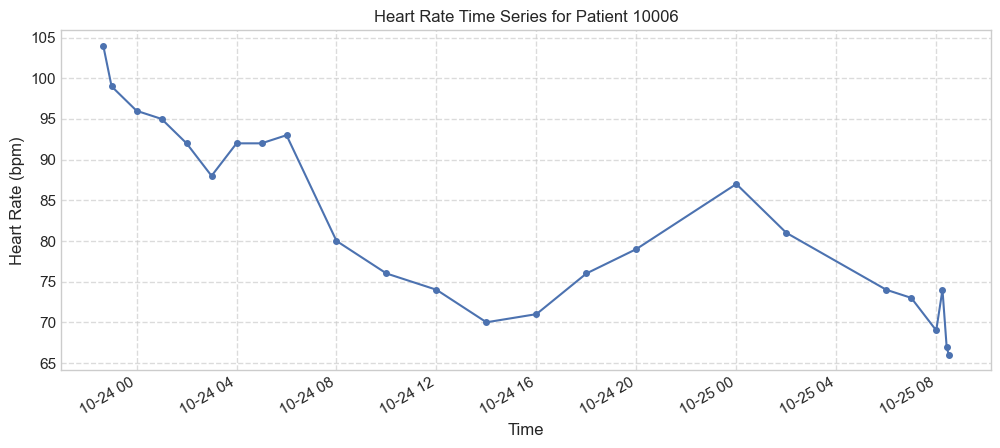

In [7]:
# Extract heart rate for our patient
heart_rate_series = extract_vital_sign_series(timeline_df, 'heart_rate')

# If we couldn't find heart rate directly, try getting it from the signal processor
if len(heart_rate_series) < 10 and 'event_type' in timeline_df.columns:
    chart_events = timeline_df[timeline_df['event_type'] == 'chart'].copy()
    
    # Use the preprocessing from signal processor
    heart_rate_data = signal_processor.preprocess_timeseries(chart_events, 'heart_rate')
    if heart_rate_data is not None and len(heart_rate_data) > 0:
        heart_rate_series = heart_rate_data

print(f"\nExtracted heart rate series with {len(heart_rate_series)} measurements")

# Plot the time series
if len(heart_rate_series) > 0:
    plt.figure(figsize=(12, 5))
    heart_rate_series.plot(marker='o', linestyle='-', markersize=4)
    plt.title(f'Heart Rate Time Series for Patient {patient_id}')
    plt.ylabel('Heart Rate (bpm)')
    plt.xlabel('Time')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Not enough heart rate data for this patient")

## 5. State Space Reconstruction

Optimal time delay: 6
Using fixed embedding dimension: 3


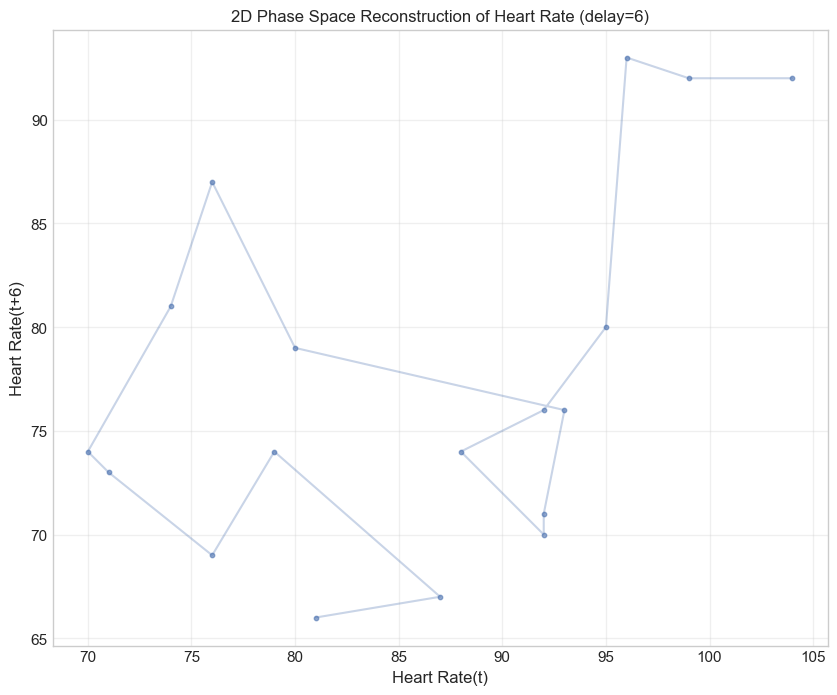

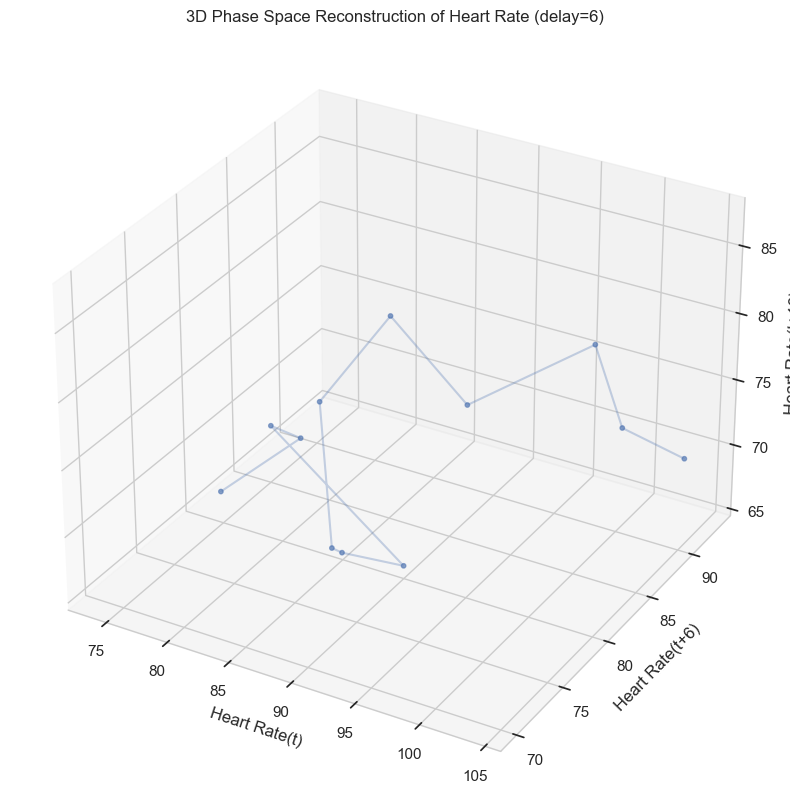

In [8]:
# Check if we have enough data
if len(heart_rate_series) >= 20:
    # Find optimal time delay using mutual information
    optimal_delay = ds_modeler.estimate_optimal_time_delay(heart_rate_series.values, method='autocorr')
    print(f"Optimal time delay: {optimal_delay}")
    
    # COMMENT OUT THESE LINES:
    # optimal_dim, embed_info = ds_modeler.estimate_embedding_dimension(
    #     heart_rate_series.values, 
    #     time_delay=optimal_delay
    # )
    # print(f"Optimal embedding dimension: {optimal_dim}")
    
    # Use this instead:
    optimal_dim = 3
    print(f"Using fixed embedding dimension: {optimal_dim}")
    
    # Embed in 2D for visualization (regardless of optimal dimension)
    embedded_2d = ds_modeler.time_delay_embedding(
        heart_rate_series.values, 
        embedding_dimension=2, 
        time_delay=optimal_delay
    )
    
    # Embed in 3D for visualization
    embedded_3d = ds_modeler.time_delay_embedding(
        heart_rate_series.values, 
        embedding_dimension=3, 
        time_delay=optimal_delay
    )
    
    # Plot 2D phase space
    plt.figure(figsize=(10, 8))
    plt.scatter(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.6, s=10)
    plt.plot(embedded_2d[:, 0], embedded_2d[:, 1], alpha=0.3)
    plt.title(f'2D Phase Space Reconstruction of Heart Rate (delay={optimal_delay})')
    plt.xlabel('Heart Rate(t)')
    plt.ylabel(f'Heart Rate(t+{optimal_delay})')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Plot 3D phase space if we have enough points
    if len(embedded_3d) > 0:
        fig = plt.figure(figsize=(12, 10))
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(embedded_3d[:, 0], embedded_3d[:, 1], embedded_3d[:, 2], alpha=0.6, s=10)
        ax.plot(embedded_3d[:, 0], embedded_3d[:, 1], embedded_3d[:, 2], alpha=0.3)
        ax.set_title(f'3D Phase Space Reconstruction of Heart Rate (delay={optimal_delay})')
        ax.set_xlabel('Heart Rate(t)')
        ax.set_ylabel(f'Heart Rate(t+{optimal_delay})')
        ax.set_zlabel(f'Heart Rate(t+{2*optimal_delay})')
        plt.show()
else:
    print("Not enough data points for state space reconstruction")

## 6. Stability Analysis

In [9]:
# Perform stability analysis if we have enough data
if len(heart_rate_series) >= 50:
    print("\nPerforming stability analysis...")
    
    # Calculate maximal Lyapunov exponent
    lyapunov, lyap_info = ds_modeler.calculate_lyapunov_exponent(
        heart_rate_series.values,
        embedding_dimension=optimal_dim,
        time_delay=optimal_delay
    )
    print(f"Maximal Lyapunov exponent: {lyapunov:.4f}")
    print(f"  Based on {lyap_info.get('n_rates', 0)} trajectory pairs")
    
    # Interpret the Lyapunov exponent
    if np.isnan(lyapunov):
        print("  Interpretation: Insufficient data for stability assessment")
    elif lyapunov < -0.05:
        print("  Interpretation: System shows strong stability (convergence to fixed point)")
    elif lyapunov < 0:
        print("  Interpretation: System shows mild stability")
    elif lyapunov < 0.05:
        print("  Interpretation: System is marginally stable (possible limit cycle)")
    else:
        print("  Interpretation: System shows chaotic dynamics (sensitive to initial conditions)")
    
    # Calculate recurrence plot
    recurrence_matrix, recur_info = ds_modeler.calculate_recurrence_plot(
        heart_rate_series.values,
        embedding_dimension=optimal_dim,
        time_delay=optimal_delay
    )
    
    # Plot the recurrence plot
    if len(recurrence_matrix) > 0:
        plt.figure(figsize=(10, 8))
        plt.imshow(recurrence_matrix, cmap='binary', origin='lower')
        plt.colorbar(label='Recurrence')
        plt.title('Recurrence Plot of Heart Rate Dynamics')
        plt.xlabel('Time Index')
        plt.ylabel('Time Index')
        plt.show()
        
        # Calculate recurrence quantification measures
        rqa = ds_modeler.calculate_recurrence_quantification(recurrence_matrix)
        print("\nRecurrence Quantification Analysis:")
        print(f"  Recurrence Rate: {rqa['recurrence_rate']:.4f}")
        print(f"  Determinism: {rqa['determinism']:.4f}")
        print(f"  Laminarity: {rqa['laminarity']:.4f}")
        print(f"  Average Diagonal Line Length: {rqa['average_diagonal_line']:.4f}")
        
        # Interpret RQA
        if rqa['determinism'] > 0.7:
            print("  Interpretation: High determinism indicates predictable dynamics")
        elif rqa['determinism'] > 0.3:
            print("  Interpretation: Moderate determinism indicates some predictability")
        else:
            print("  Interpretation: Low determinism indicates stochastic or chaotic dynamics")
    
    # Detect fixed points and limit cycles
    attractor_info = ds_modeler.detect_fixed_points(
        heart_rate_series.values,
        embedding_dimension=optimal_dim,
        time_delay=optimal_delay
    )
    
    # Report on fixed points
    if attractor_info['fixed_points']:
        print(f"\nDetected {len(attractor_info['fixed_points'])} potential fixed points:")
        for i, fp in enumerate(attractor_info['fixed_points']):
            print(f"  Fixed Point {i+1}:")
            print(f"    Value: {fp['value']}")
            print(f"    Duration: {fp['duration']} time points")
    else:
        print("\nNo fixed points detected")
    
    # Report on limit cycles
    if attractor_info['limit_cycles']:
        print(f"\nDetected {len(attractor_info['limit_cycles'])} potential limit cycles:")
        for i, lc in enumerate(attractor_info['limit_cycles']):
            print(f"  Limit Cycle {i+1}:")
            print(f"    Period: {lc['period']} time units")
            print(f"    Duration: {lc['duration']} time points")
    else:
        print("\nNo limit cycles detected")
else:
    print("Not enough data points for stability analysis")

Not enough data points for stability analysis


## 7. Critical Transition Detection

In [10]:
# Detect critical transitions if we have enough data
if len(heart_rate_series) >= 50:
    print("\nPerforming critical transition detection...")
    
    # Calculate early warning signals
    ews = ds_modeler.calculate_early_warning_signals(heart_rate_series.values)
    
    # Check if we have EWS results
    if 'error' not in ews and len(ews['variance']) > 0:
        # Plot the early warning signals
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        
        # Variance
        axes[0, 0].plot(ews['window_indices'], ews['variance'], 'b-')
        axes[0, 0].set_title('Variance')
        axes[0, 0].set_xlabel('Window Index')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Autocorrelation
        axes[0, 1].plot(ews['window_indices'], ews['autocorrelation'], 'r-')
        axes[0, 1].set_title('Lag-1 Autocorrelation')
        axes[0, 1].set_xlabel('Window Index')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Skewness
        axes[1, 0].plot(ews['window_indices'], ews['skewness'], 'g-')
        axes[1, 0].set_title('Skewness')
        axes[1, 0].set_xlabel('Window Index')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Kurtosis
        axes[1, 1].plot(ews['window_indices'], ews['kurtosis'], 'm-')
        axes[1, 1].set_title('Kurtosis')
        axes[1, 1].set_xlabel('Window Index')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.suptitle('Early Warning Signals for Critical Transitions', y=1.02, fontsize=16)
        plt.show()
        
        # Detect critical transitions
        transition = ds_modeler.detect_critical_transition(heart_rate_series.values)
        
        print("\nCritical Transition Detection Results:")
        print(f"  Critical transition detected: {transition['detected']}")
        print(f"  Transition probability: {transition['probability']:.4f}")
        
        if transition['detected']:
            print(f"  Potential transition point: {transition['transition_point']}")
            print("  Warning: The patient may be approaching a critical transition in physiological state")
        else:
            print("  No evidence of an approaching critical transition")
    else:
        print("  Insufficient data for early warning signal calculation")
else:
    print("Not enough data points for critical transition detection")

Not enough data points for critical transition detection


## 8. Physiological System Modeling


Simulating cardiovascular system dynamics...
  Simulating normal cardiovascular function...
  Simulating altered cardiovascular function (hypertensive)...


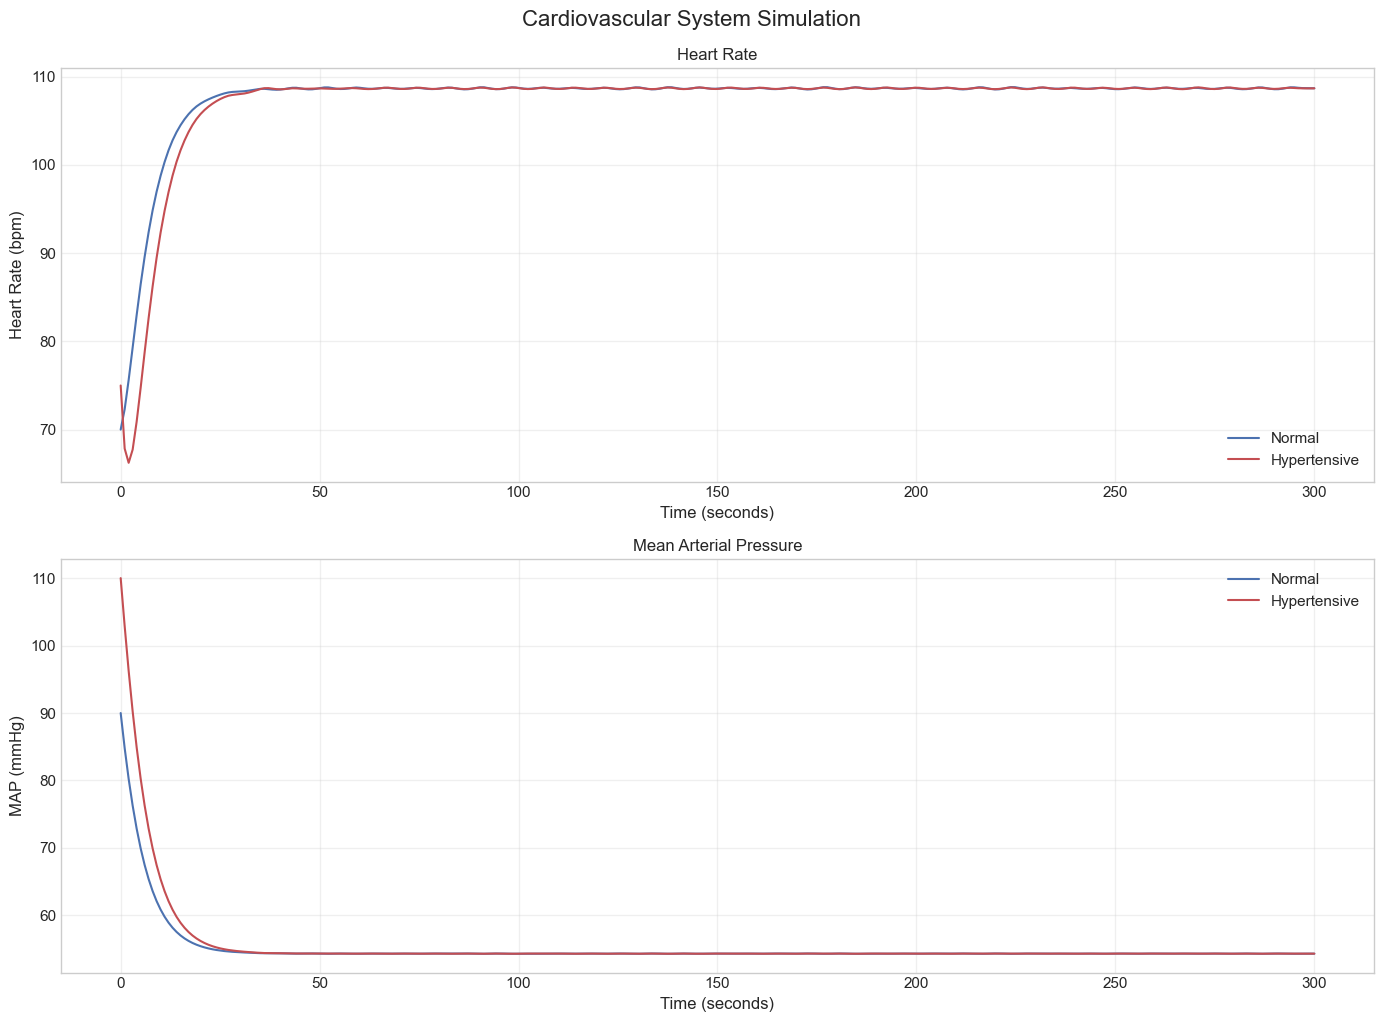


Simulating respiratory system dynamics...
  Simulating normal respiratory function...
  Simulating altered respiratory function (hyperventilation)...


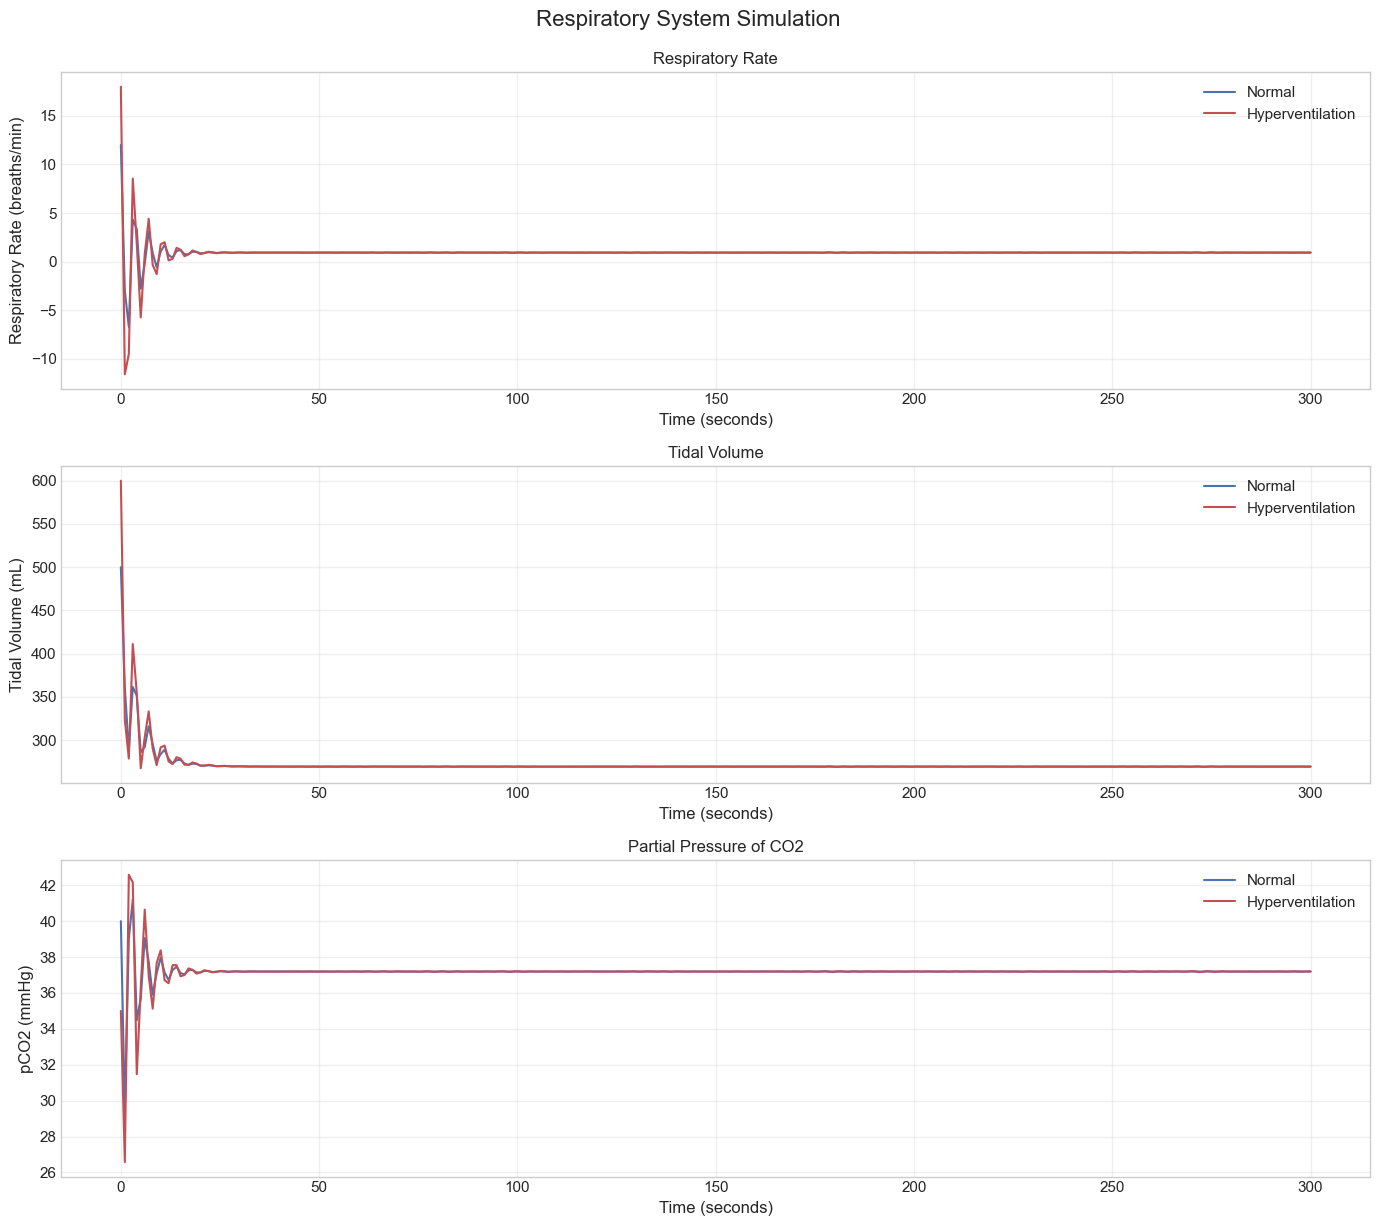

In [11]:
# Demonstrate physiological system modeling (cardiovascular)
print("\nSimulating cardiovascular system dynamics...")

# Generate time points for simulation (5 minutes)
time_points = np.linspace(0, 300, 300)

# Simulate normal cardiovascular system
print("  Simulating normal cardiovascular function...")
normal_initial = [70, 90]  # HR: 70 bpm, MAP: 90 mmHg
normal_time, normal_states = ds_modeler.simulate_physiological_system(
    'cardiovascular', 
    duration_seconds=300, 
    initial_state=normal_initial
)

# Simulate altered cardiovascular system (e.g., hypertensive)
print("  Simulating altered cardiovascular function (hypertensive)...")
altered_params = ds_modeler.system_parameters['cardiovascular'].copy()
altered_params['vascular_resistance'] = 1.5  # Increased vascular resistance
altered_initial = [75, 110]  # HR: 75 bpm, MAP: 110 mmHg
altered_time, altered_states = ds_modeler.simulate_physiological_system(
    'cardiovascular', 
    duration_seconds=300, 
    initial_state=altered_initial
)

# Plot the simulation results
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Heart Rate
axes[0].plot(normal_time, normal_states[:, 0], 'b-', label='Normal')
axes[0].plot(altered_time, altered_states[:, 0], 'r-', label='Hypertensive')
axes[0].set_title('Heart Rate')
axes[0].set_ylabel('Heart Rate (bpm)')
axes[0].set_xlabel('Time (seconds)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Blood Pressure
axes[1].plot(normal_time, normal_states[:, 1], 'b-', label='Normal')
axes[1].plot(altered_time, altered_states[:, 1], 'r-', label='Hypertensive')
axes[1].set_title('Mean Arterial Pressure')
axes[1].set_ylabel('MAP (mmHg)')
axes[1].set_xlabel('Time (seconds)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Cardiovascular System Simulation', y=1.02, fontsize=16)
plt.show()

# Demonstrate respiratory system modeling
print("\nSimulating respiratory system dynamics...")

# Simulate normal respiratory system
print("  Simulating normal respiratory function...")
normal_initial_resp = [12, 500, 40]  # RR: 12/min, TV: 500mL, pCO2: 40mmHg
normal_time_resp, normal_states_resp = ds_modeler.simulate_physiological_system(
    'respiratory', 
    duration_seconds=300, 
    initial_state=normal_initial_resp
)

# Simulate altered respiratory system (e.g., hyperventilation)
print("  Simulating altered respiratory function (hyperventilation)...")
altered_params_resp = ds_modeler.system_parameters['respiratory'].copy()
altered_params_resp['respiratory_drive'] = 1.5  # Increased respiratory drive
altered_initial_resp = [18, 600, 35]  # RR: 18/min, TV: 600mL, pCO2: 35mmHg
altered_time_resp, altered_states_resp = ds_modeler.simulate_physiological_system(
    'respiratory', 
    duration_seconds=300, 
    initial_state=altered_initial_resp
)

# Plot the simulation results
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Respiratory Rate
axes[0].plot(normal_time_resp, normal_states_resp[:, 0], 'b-', label='Normal')
axes[0].plot(altered_time_resp, altered_states_resp[:, 0], 'r-', label='Hyperventilation')
axes[0].set_title('Respiratory Rate')
axes[0].set_ylabel('Respiratory Rate (breaths/min)')
axes[0].set_xlabel('Time (seconds)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Tidal Volume
axes[1].plot(normal_time_resp, normal_states_resp[:, 1], 'b-', label='Normal')
axes[1].plot(altered_time_resp, altered_states_resp[:, 1], 'r-', label='Hyperventilation')
axes[1].set_title('Tidal Volume')
axes[1].set_ylabel('Tidal Volume (mL)')
axes[1].set_xlabel('Time (seconds)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# pCO2
axes[2].plot(normal_time_resp, normal_states_resp[:, 2], 'b-', label='Normal')
axes[2].plot(altered_time_resp, altered_states_resp[:, 2], 'r-', label='Hyperventilation')
axes[2].set_title('Partial Pressure of CO2')
axes[2].set_ylabel('pCO2 (mmHg)')
axes[2].set_xlabel('Time (seconds)')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Respiratory System Simulation', y=1.02, fontsize=16)
plt.show()

## 9. Comprehensive Patient Stability Analysis

In [12]:
# Perform comprehensive stability analysis on the patient
print("\nPerforming comprehensive patient stability analysis...")

# Analyze patient stability across all vital signs
stability_report = ds_modeler.create_stability_report(patient_timeline)

# Check if analysis was successful
if 'error' not in stability_report:
    print("\nStability report generated successfully!")
    
    # Print patient ID
    print(f"Patient ID: {stability_report['patient_id']}")
    
    # Print vital sign analyses
    print("\nVital Signs Analyzed:")
    for vital, analysis in stability_report.get('vital_sign_analysis', {}).items():
        print(f"  - {vital}: {analysis.get('n_measurements', 0)} measurements")
    
    # Print system stability assessments
    print("\nPhysiological System Stability:")
    for system, status in stability_report.get('system_stability', {}).items():
        print(f"  {system.title()} System:")
        print(f"    Stability: {status.get('classification', 'Unknown')}")
        print(f"    Stability Score: {status.get('stability_score', 0):.2f}")
        if status.get('has_critical_transition', False):
            print(f"    WARNING: Approaching critical transition")
    
    # Print overall assessment
    print("\nOverall Stability Assessment:")
    assessment = stability_report.get('overall_assessment', {})
    print(f"  Classification: {assessment.get('stability_classification', 'Unknown')}")
    print(f"  Average Lyapunov Exponent: {assessment.get('average_lyapunov_exponent', 'Unknown')}")
    
    if assessment.get('systems_with_transitions', []):
        print("\n  WARNING: The following systems show signs of critical transitions:")
        for system in assessment['systems_with_transitions']:
            print(f"    - {system}")
        print(f"  Maximum transition probability: {assessment.get('maximum_transition_probability', 0):.2f}")
else:
    print(f"Error generating stability report: {stability_report.get('error')}")


Performing comprehensive patient stability analysis...

Stability report generated successfully!
Patient ID: 10006

Vital Signs Analyzed:
  - heart_rate: 24 measurements
  - respiratory_rate: 24 measurements

Physiological System Stability:
  Cardiovascular System:
    Stability: Unknown
    Stability Score: 0.00
  Respiratory System:
    Stability: Unknown
    Stability Score: 0.00

Overall Stability Assessment:
  Classification: Unknown
  Average Lyapunov Exponent: Unknown


## 10. Interpretation and Clinical Significance

In [13]:
# Wrap up with interpretation of the dynamical systems analysis
print("\nInterpretation of Dynamical Systems Analysis:")

# Create a simple scoring system for clinical interpretation
def interpret_stability(stability_report):
    """Interpret stability report in clinical terms."""
    if 'error' in stability_report:
        return "Insufficient data for clinical interpretation"
    
    # Get overall assessment
    assessment = stability_report.get('overall_assessment', {})
    
    # Calculate a simple score based on components
    clinical_insights = []
    
    # Check Lyapunov exponent
    if 'average_lyapunov_exponent' in assessment:
        lyapunov = assessment['average_lyapunov_exponent']
        if not np.isnan(lyapunov):
            if lyapunov < -0.1:
                clinical_insights.append("Highly stable physiological dynamics, indicating good homeostatic control")
            elif lyapunov < 0:
                clinical_insights.append("Stable physiological dynamics")
            elif lyapunov < 0.1:
                clinical_insights.append("Marginally stable physiological dynamics, suggesting diminished homeostatic reserve")
            else:
                clinical_insights.append("Unstable physiological dynamics, indicating potential homeostatic failure")
    
    # Check for critical transitions
    if assessment.get('systems_with_transitions', []):
        probability = assessment.get('maximum_transition_probability', 0)
        if probability > 0.7:
            clinical_insights.append("High probability of imminent critical transition, suggesting urgent clinical attention")
        elif probability > 0.4:
            clinical_insights.append("Moderate probability of approaching critical transition, warrants increased monitoring")
        else:
            clinical_insights.append("Early signs of potential critical transition, suggests preventive intervention")
    
    # Per-system interpretation
    system_insights = []
    for system, status in stability_report.get('system_stability', {}).items():
        if 'stability_score' in status:
            score = status['stability_score']
            if score < 0.3 and status.get('has_critical_transition', False):
                system_insights.append(f"Critical instability in {system} system requiring immediate attention")
            elif score < 0.4:
                system_insights.append(f"Significant instability in {system} system")
            elif score < 0.6 and status.get('has_critical_transition', False):
                system_insights.append(f"Moderate instability in {system} system with signs of deterioration")
    
    return clinical_insights, system_insights

# Get clinical interpretation
clinical_insights, system_insights = interpret_stability(stability_report)

# Print clinical insights
print("\nClinical Insights from Dynamical Systems Analysis:")
for insight in clinical_insights:
    print(f"  • {insight}")

# Print system-specific insights
if system_insights:
    print("\nSystem-Specific Clinical Insights:")
    for insight in system_insights:
        print(f"  • {insight}")

# Summarize the benefits of dynamical systems approach
print("\nAdvantages of Dynamical Systems Approach in Clinical Analysis:")
print("  • Detects subtle changes in physiological stability before conventional alerts trigger")
print("  • Quantifies regulatory system performance beyond simple threshold violations")
print("  • Identifies early warning signals for clinical deterioration")
print("  • Provides mechanistic insights into physiological system interactions")
print("  • Enables personalized assessment of homeostatic reserve")


Interpretation of Dynamical Systems Analysis:

Clinical Insights from Dynamical Systems Analysis:

System-Specific Clinical Insights:
  • Significant instability in cardiovascular system
  • Significant instability in respiratory system

Advantages of Dynamical Systems Approach in Clinical Analysis:
  • Detects subtle changes in physiological stability before conventional alerts trigger
  • Quantifies regulatory system performance beyond simple threshold violations
  • Identifies early warning signals for clinical deterioration
  • Provides mechanistic insights into physiological system interactions
  • Enables personalized assessment of homeostatic reserve


In [ ]:
## 11. Summary

In [16]:
print("\n=== BioDynamICS Dynamical Systems Analysis Summary ===")
print(f"Patient ID: {patient_id}")
print(f"Analyzed {len(heart_rate_series)} heart rate measurements")

if 'error' not in stability_report:
    assessment = stability_report.get('overall_assessment', {})
    classification = assessment.get('stability_classification', 'Unknown')
    print(f"Overall stability classification: {classification}")
    
    # Count systems with transitions
    systems_with_transitions = assessment.get('systems_with_transitions', [])
    if systems_with_transitions:
        print(f"WARNING: {len(systems_with_transitions)} physiological systems show signs of critical transitions")
    else:
        print("No critical transitions detected")
else:
    print("Insufficient data for complete stability analysis")

print("\nBioDynamICS dynamical systems analysis complete!")


=== BioDynamICS Dynamical Systems Analysis Summary ===
Patient ID: 10006
Analyzed 24 heart rate measurements
Overall stability classification: Unknown
No critical transitions detected

BioDynamICS dynamical systems analysis complete!
